In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os
import umap
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict


2023-12-30 05:59:00.031394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [43]:
model_name = 'enformer'
data_dir = '../data/'
test_results = f'../results/distance_test_True/{model_name}/'

pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/distance_test/')

In [13]:
tile_coords = pd.read_csv(f'../results/summary_csvs/{model_name}/sufficiency_test_tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000

In [6]:
cre_df = pd.read_csv(f'../results/summary_csvs/{model_name}/sufficient_CREs.csv')


In [7]:
cre_df.groupby(['cell_line', 'context', 'tile class']).count()['seq_id']

cell_line  context    tile class
GM12878    enhancing  Enhancer       41
           silencing  Silencer       57
K562       enhancing  Enhancer       74
           silencing  Silencer      222
PC-3       enhancing  Enhancer       35
           silencing  Silencer       97
Name: seq_id, dtype: int64

In [8]:
cre_df['tile start relative to tss'] =  np.abs(cre_df['tile_start'] - tss_tile[0]) // 1000


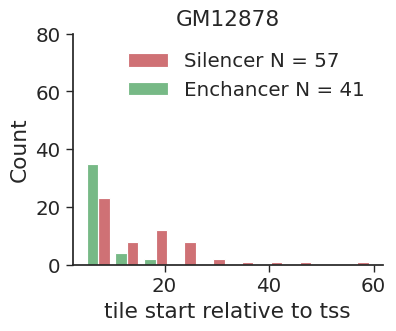

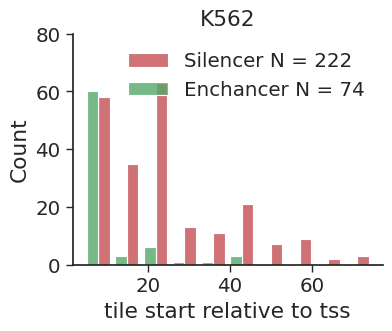

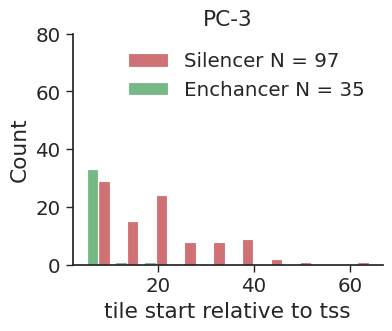

In [44]:

sns.set(font_scale = 1.3)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in cre_df.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[4,3])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False)
    plt.title(cell)
    fig.savefig(f'{pdf_dir}/CRE_frequency_vs_distance.pdf')
    plt.show()
    

In [10]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'{data_dir}/{model_name}_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
cell_lines

['PC-3', 'GM12878', 'K562']

In [29]:
compiled_res = OrderedDict()
for i, cell_line in enumerate(cell_lines):
    compiled_res[cell_line] = {'Enhancer': [], 
                               'Silencer': []}

    cre_df_cell = cre_df[cre_df['cell_line'] == cell_line]

    for j, (_, row) in tqdm(enumerate(cre_df_cell.iterrows())):
        tile_start, tile_end = [row['tile_start'], row['tile_end']]
        result_path = f'{test_results}/{row["seq_id"]}_{tile_start}_{tile_end}.pickle'
        res = utils.read_pickle(result_path)
        control = res['mean_control'][447:449,i].mean()
        test = res['mean_mut'][:, 447:449, i].mean(axis=-1)
        # norm_effects = test / control
        norm_effects = test / np.max(test)
        compiled_res[cell_line][row['tile class']].append(norm_effects)



132it [00:00, 4888.85it/s]
98it [00:00, 4779.94it/s]
296it [00:00, 4865.36it/s]


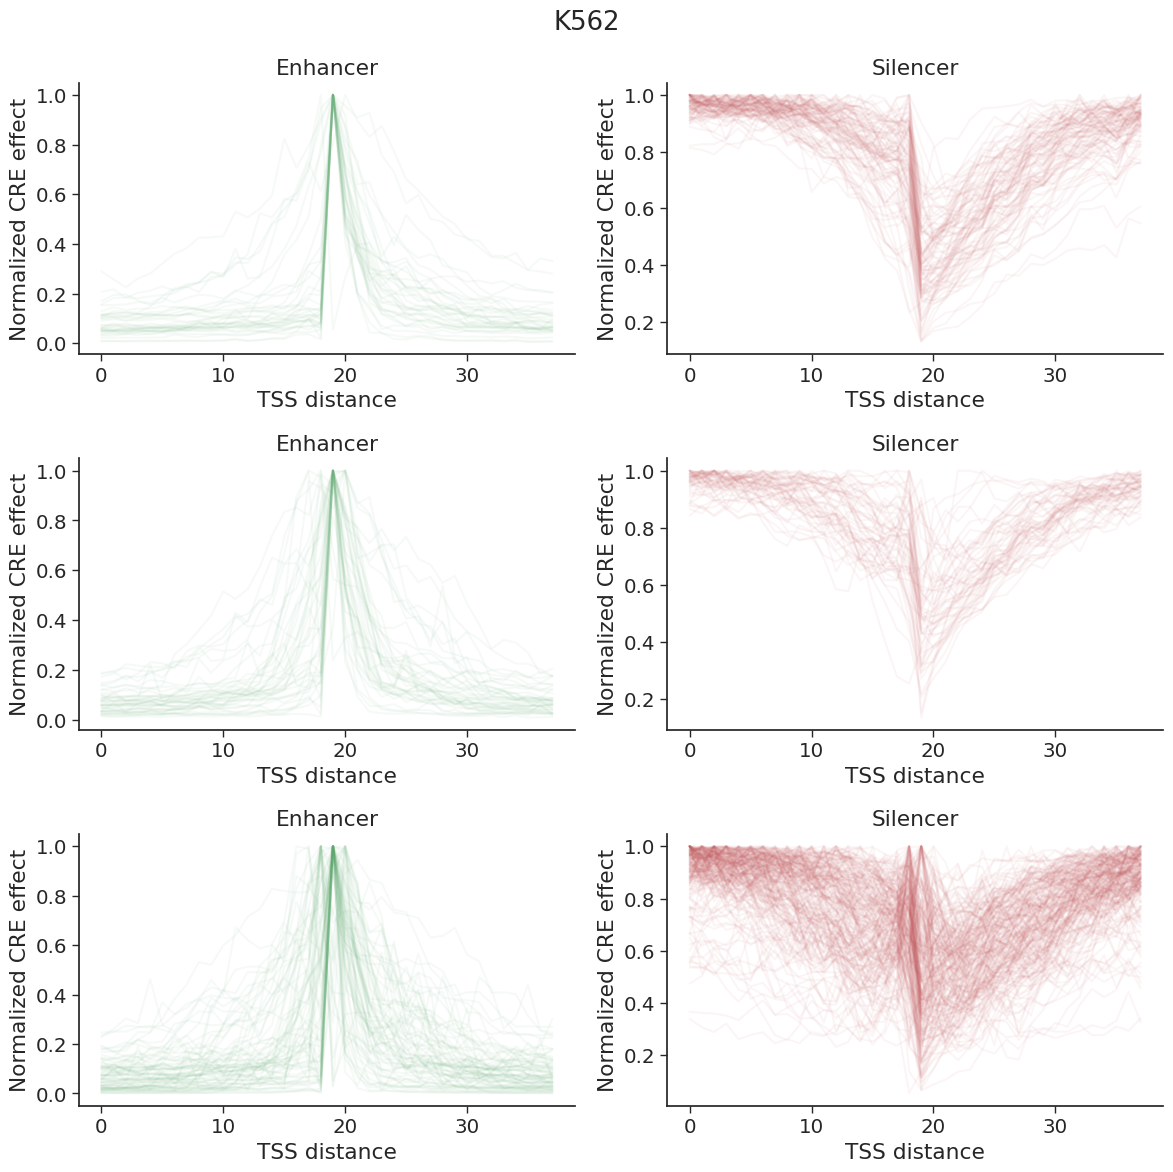

In [45]:
context_color_map = {'Silencer': 'r', 'Enhancer': 'g'}
fig, axes = plt.subplots(3, 2, figsize=[12, 12])

for c, cell_line in enumerate(['PC-3', 'GM12878', 'K562']):

    for e, (cre, traces)  in enumerate(compiled_res[cell_line].items()):
        
        for line in traces:
            axes[c, e].plot(line, alpha=0.05, color=context_color_map[cre])
        axes[c, e].set_title(f'{cre}')
        axes[c, e].spines['top'].set_visible(False)
        axes[c, e].spines['right'].set_visible(False)
        axes[c, e].set_xlabel('TSS distance')
        axes[c, e].set_ylabel('Normalized CRE effect')


    plt.suptitle(cell_line)
    
plt.tight_layout()
fig.savefig(f'{pdf_dir}/CRE_effect_vs_distance.pdf')
